# Milestone 2

## Introduction
Differentiation is used in many applications, such as finding stationary points of defined functions or minimizing objective loss functions in machine learning applications. 
But differentiating an arbitrary function &#8477;<sup>n</sup> &#8594; &#8477;<sup>m</sup> is generally not an easy task. 
When the function can be expressed as a composition of differentiable elementary functions (which in most cases is true), Automatic Differentiation (AD) can help. 
AD has become one of the most popular techniques for finding derivatives and is often preferred over symbolic differentation and numerical differentiation because of its efficiency and stability.

 
## Background

How does AD do it? AD takes an input function and breaks it down into a set of elementary functions. It uses symbolic differentiation of the elementary functions to calculate their derivatives at specific values. These elementary functions are then combined using common mathematical functions, such as addition or multiplication. The derivatives of the combined functions (which we will refer to as nodes) can be found using the chain rule and the derivatives calculated from the earlier elementary functions. This process repeats (as more complex functions are combined) until the function's derivative has been calculated. As an example, if you want to compute the derivative of *sin(tan(xy) + cos(x + y))* you can first compute the derivatives with respect to the inputs *x,y* of *tan(xy)* and *cos(x + y)*, add those together, and then get the derivative of the entire function using the chain rule. 

There are two common methods for implementing AD, forward mode and backward mode (of which the popular backpropagation algorithm for neural networks is a special case). Given a function &#8477;<sup>n</sup> &#8594; &#8477;<sup>m</sup>, forward mode fixes the independent variables or n inputs to solve for m outputs; whereas backward mode fixes the dependent variables or m outputs. This means that forward mode is more efficient when m>>n and backward mode is more efficient when n>>m.

The AD process can be represented using a computational trace or a computation graph. The computational trace is a table that stores the elementary and intermediary functions, their derivatives, and the derivative values evaluated at an input (if provided). This process can also be visually representated using a computational graph whose nodes are the same as the rows in the computational trace. Nodes are connect to show how nodes are combined and by what elementary operations. 

## How to Use funkyAD

The software funkyAD is a software package that the user will interact with using the AD class. This AD class allows the user to differentiate a specified function by wrapping it into an AD object, automatically differentiate it, and access the results. The package is intended for use by developers on personal computers, as a building block on top of which other functionality may be developed. We recommend users download the package using PyPi. A minimal installation in a fresh virtual environment might proceed as follows:

    conda create -n funky python=3.6
    source activate funky

Then, to install funkyAD with PyPi use the following command:

	pip install -i https://test.pypi.org/simple/ funkyAD-funkyADers

    
You are now ready to use the package! Please see examples below.

#### Importing funkyAD after installation

In [2]:
# After installing the package, import base from funkyAD
from funkyAD.base import AD, grad, Node

#### Basic examples of funkyAD

funkyAD supports both scalar and vector functions. 

In [12]:
# show basic functionality of funkyAD
def f1(x):
    return x ** 3

ad_object = AD(f1)
print(ad_object.grad(2))
print(ad_object.grad(3))

[[12.]]
[[27.]]


In [13]:
def f2(x, y):
    return x + y

print(AD(f2).grad(3, 5))

[[1. 1.]]


In [10]:
# Package supports variable number of inputs/outputs 
import numpy as np
def f3(a: np.array):
    return a.sum()
print(AD(f3).grad(np.array([3, 5, 7])))
print(AD(f3).grad(np.array([3, 5, 7, 9, 11])))

[[1. 1. 1.]]
[[1. 1. 1. 1. 1.]]


In [11]:
# Package supports multiple outputs
def f4(x):
    return x ** 2, -x, 5 * x
    # equivalently can also return a np.array() object
print(AD(f4).grad(4))

[[ 8.]
 [-1.]
 [ 5.]]


#### Alternative ways to access the gradient
While funkyAD can be directly called as shown above, we have also created a function so that you can get the gradient directly without going through the AD object, in case this is a more intuitve way to get the gradient. The grad method creates the AD object on the function implicitely. 

In [4]:
# One way to get the derivative
def f5(x):
    return x**2

print(AD(f5).grad(1))

# Alternative way
print(grad(f5)(1))

[[2.]]
[[2.]]


#### Using elementary functions in funkyAD
FunkyAD supports many elementary function operations such as addition, subtraction, exponents, and trigonometric functions like cosine, etc. In order to access built in functions that aren't already implicitely overloaded (e.g. addition), you need to import them from the funkyAD functions module. 

In [14]:
from funkyAD.functions import exp 

def f6(x):
    return exp(x)

print(AD(f6).grad(1))


[[2.7182817]]


#### Adding a user-defined arbitrary function
Currently, the package only supports a subset of the possible elementary function that a user might want to use. To extend the library with a new Elementary Function, the user must provide the function and its derivative, and wrap them into a BaseFunction object as follows:

In [34]:
from funkyAD.functions import BaseFunction

def sigmoid(x):
    # Use x.v for the value of x
    return np.exp(x.v) / (1 + np.exp(x.v))

def sigmoid_derivative(x):
    # Use x.v for the value, x.d for the derivative of the argument (x dot)
    return x.d * np.exp(-x.v) / (1 + np.exp(-x.v)) ** 2

sig = BaseFunction(sigmoid, sigmoid_derivative)

print(grad(sig)(3))

[[0.04517666]]


In [35]:
# You can also use sig as a part of a larger function as follows:
def f7(x, y):
    return sig(x ** 2), x + sig(y)
print(grad(f7)(2, 1))

[[0.07065083 0.        ]
 [1.         0.19661194]]


In [36]:
# Multiple input functions are also supported
weird_add = BaseFunction(lambda x, y: 2 * x.v + y.v, lambda x, y: 2 * x.d + y.d)
print(grad(weird_add)(3, 4))

[[2. 1.]]


#### Using funky AD for Newton's Method

funkyAD can be used for more than just deriving derivatives of simple functions. One use case is for root finding. Newton's Method is a root-finding algorithm that finds roots using an iteration approach: 

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$

This algorithm requires calculating the derivative in order to update. funkyAD can be used to find the derivative in this case. Take the function $f(x)=x^2+x$. It has two roots, one at -1 and another at 0. Using Newton's Method we can find both these roots by using different initialization points (e.g. if we always pick a positive initialization point, then the only root it will find is 0). Please see below for the code and results. 

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# create newton root method using funkyAD to find the Jacobian of the function
def newtonroot(f, x):
    fx = f(x)
    dfx = AD(f).grad(x) # alternatively this can be written grad(f)(x)
    x_next = x - fx/dfx 
    return x_next 

def get_root(f,x_start):
    delta = 10
    path = [x_start]
    x = x_start
    while delta > 1e-6:
        new_x = newtonroot(f,x) 
        path.append(new_x)
        delta = abs(x - new_x)
        x = new_x 
    return(x, path)

In [41]:
# root method for scalar function (e.g. y = f(x))
def f(x):
    return x**2+x 

# try one initialization
zero1, path1 = get_root(f, 1)

# try a different initialization 
zero2, path2  = get_root(f, -2)
print(zero1, zero2)

[[0.]] [[-1.]]


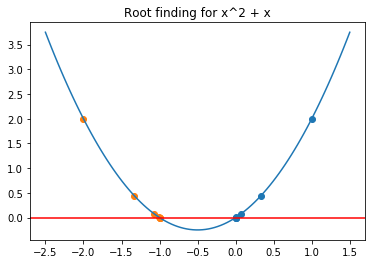

In [40]:
xs = np.linspace(-2.5, 1.5, 100)
path1_ys = [f(x) for x in path1]
path2_ys = [f(x) for x in path2]


plt.plot(xs, f(xs))
plt.axhline(y=0, color='r', linestyle='-')
plt.scatter(path1, path1_ys)
plt.scatter(path2, path2_ys)
plt.title('Root finding for x^2 + x')
plt.show()

## Software Organization

#### Directory Structure: 
```
.
| README.md
| LICSENSE
| requirements.txt 
| setup.py
| .travis.yml
| .gitignore 
| 
|--docs
|  | milestone1.md
|  | milestone2.ipynb
|  |-examples
|  | |- AD_users_intro.ipynb 
|  | |- example1.py
|
|--src/funkyAD
|  | __init__.py 
|  | base.py
|  | functions.py 
|  | helpers.py
|
|--tests
|  | test_base.py
|  | test_functions.py
|  | test_helpers.py
```

#### Modules (functionality)

The funkyAD package stored within the \src directory contains 3 modules: base.py, functions.py, and helpers.py. 

The **base module** defines the AD class and the Node class. The AD class takes a function as an input and initiates forward differentiation to find the gradient of the function at a given value. The input functions is broken down into nodes (defined by the Node class) which store the value and derivative for each input and combined nodes. 

The **functions module** defines the values and derivatives of elementary functions (e.g. sin, exponents, addition, and multiplication). Since we are working with Node objects, they are all compatable with nodes. 

The **helpers module** includes helper functions such as figuring out the number of inputs in a function and turning all inputs into nodes. 

#### Test suite
we use TravisCI, CodeCov, doctests and unittests for testing. Our test suite lives in the /tests folder at the project root. We have three testing programs (test_base.py, test_functions.py, test_helpers.py) for each module. They check for basic functionality of classes and functions, test that exceptions are handled properly, and verify that our functions work in various edge cases and with different input arrays. 

For testing, we follow the packainging advise outlined at http://doc.pytest.org/en/latest/goodpractices.html. We use a virtual environment and pip for installing funkyAD and any dependencies. The virtual environment ensures that we are testing the package as if we were any user, independent of whatever local Python version or packages we already have downloaded. By running tests on the local package, it also ensures we aren't running the tests on earlier installed vesions. To run the tests on a packaged version of the source code the following commands are required at the root of the repository: 

	pip install -r requirements.txt
    pip install -e . 

The first line installs any requirements. The second line installs an editable version of the package so that the package updates if you make changes to tests or source code. Because of this set-up we need to explicitely tell Travis which package to run tests on. This infomation is stored in the setup.py file. 

#### Software Packaging & Distribution 


The funkyAD package will be distributed with PyPI. Consequently, users will be able to install the package using the ubiquitous pip package manager. It will follow the guidelines and instructions in the official Python documentation. 

	pip install -r requirements.txt
	pip install -i https://test.pypi.org/simple/ funkyAD-funkyADers==0.0.4
    
We recommend using a virtual environment, which can be started with the following command before downloading the package: 

	conda create -n env_name python=3.6 anaconda
	source activate env_name


## Implementation

funkyAD has three modules (base.py, functions.py, and helpers.py), which we will describe in more detail here.

##### base.py 

*AD Class* - The AD class takes a function as input and has four parameters for storing the function (self.f), the seed (self.seed), the input dimension (self.n), and the output dimension (self.m). The input function is initialized automatically but the remaining parameters are not filled in until the user calls AD's grad function, which calls AD's private function \_evaluate to find the derivative of the function at the values specified in the grad function (e.g. AD(f).grad(2) finds the gradient of function f at 2). \_evaluate first determines the number of inputs and outputs (self.n and self.m, respectively) in the given function. We handle non-scalar functions by storing everything in ndarrays. After determining the dimension of the inputs and outputs,\_evaluate sets the seed if the user hasn't done that already, checking to make sure the seed is of the right dimension and input type. Then, \_evaluate calls the helper function nodify to convert all values to Nodes (described below), which are returned to the grad function and the derivatives returned to the user as an ndarray using the helper function \_unpack. 

*Node Class* - The Node class defines a node, which has two parameters: a value and a derivative. Nodes are connected and can be added or multiplied together to form new nodes, via the dunder methods\_\_add\_\_ etc. These dunder methods are overloaded with elementary functions defined in the functions.py file. We check to make sure all values and derivatives are numeric, i.e. it does not support strings. 

*Grad function* -  As syntatic sugar, we also define a function grad which calls the AD class implicitely to return the gradient.  

##### functions.py 
The ElementaryFunction Class defines the functions and derivatives of elementary functions passed in by the user, such as sin, log, etc. The user can use these functions in function defintions by importing them like so: 

    from funkyAD.functions import exp 

funkyAD currently supports the following elementary functions: addition, multiplication, division, power, pos, neg, abs, invert, round, floor, ceil, trun, floordiv, exp, sin, cos, tan.

We also allow the user to add their own elementary function to the list if we do not include the elementary function they need in the initial library list. An appropriate exception is raised if the user tries to utilize a function that is not defined as an instance of the ElementaryFunction class.

##### helpers.py 

Helpers defines 3 important functions (count_recursive, unpack, and nodify), which are called by the AD class to run forward mode. 

*count_recursive* takes args as input and counts the number of arguments. It is used to determine the number of inputs in a given function. 

*unpack* takes nested arrays or lists and creates a depth 1 list. This is useful for iterating  through outputs to return the derivative stored at each output node. 

*nodify* turns all inputs into nodes, storing both the value and derivative. To do this, it first checks whether each item in the args list is a ndarray, list, or other object. Depending on the type of object, it recursively sets each element in the ndarray, list, or other object as a Node with a value and a derivative and appends this to a list using the augment function defined within nodify. 


#### External dependencies

Our software package relies on numpy, which is specified in the "requirements.txt" file in the root directory. The testing suite reiles on pytest, pytest-cov, and codecov. Testing dependencies are specified in the ".travis.yml" file also in the root directory.

## Future Features

We plan to implement reverse mode for our new feature. To showcase the benefits of forward mode in some scenarios and backward mode in others, we will create a demonstration showcasing situations when one method dominates the other in terms of efficiency. For each situation, we will time how long it takes each method to differentiate the function. This will help users understand situations in which a specific mode (forward vs reverse) might be more appropriate. 

Implementing reverse mode requires storing the evaluation trace so that we can access the partial derivatives. The evaluation trace will be stored as a parameter in the AD class defined in the base.py module. For forward mode, we evaluate the derivative using the \_evaluate function. We plan to continue using this function as the work horse for performing and distributing the tasks necessary to calculate the derivative (e.g. determining the number of inputs and outputs in the function), but it will now call separate helper functions depending on whether we're performing forward versus reverse mode. These helper functions will be stored in the helpers.py module.  Additionally, we plan to write a new function in the AD class to print the evaluation trace table. In addition to these software updates, we also plan to include new examples in the \docs folder, which will include our demonstration of forward versus reverse mode efficiency.

## Manteinance of existing code

* Add more BaseFunctions to cover everything built into NumPy (at least)
* More intuitive interface for users to add BaseFunctions
* Possibility to store and display evaluation trace for faster repeated calls (caching)
* More tests to reach 100% code coverage and ensure reliability